In [1]:
import tensorflow as tf
import os
import librosa
import pandas
import matplotlib
import seaborn
from sklearn.preprocessing import LabelEncoder

In [3]:
import librosa
import numpy as np

def load_and_preprocess(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    target_length = 22050 * 3.5
    if len(y_trimmed) < target_length:
        y_padded = np.pad(y_trimmed, (0, int(target_length - len(y_trimmed))))
    else:
        y_padded = y_trimmed[:int(target_length)]
    return y_padded, sr

def extract_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return np.vstack([mfcc, mel, chroma, contrast, tonnetz]).T

def load_dataset():
    data_dirs = ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]
    emotion_map = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }

    X = []
    y = []

    for data_dir in data_dirs:
        for actor_folder in sorted(os.listdir(data_dir)):
            actor_path = os.path.join(data_dir, actor_folder)
            if not os.path.isdir(actor_path):
                continue
            for file in sorted(os.listdir(actor_path)):
                if file.endswith(".wav"):
                    try:
                        emotion_code = int(file.split("-")[2])
                        emotion_label = emotion_map.get(emotion_code)
                        if emotion_label:
                            file_path = os.path.join(actor_path, file)
                            y_audio, sr = load_and_preprocess(file_path)
                            features = extract_features(y_audio, sr)
                            X.append(features)
                            y.append(emotion_label)
                    except (IndexError, ValueError):
                        print(f"Skipping invalid filename: {file}")

    # Padding/truncating feature sequences to fixed length
    max_len = max(f.shape[0] for f in X)
    padded_X = []
    for feat in X:
        if feat.shape[0] < max_len:
            pad_width = max_len - feat.shape[0]
            feat_padded = np.pad(feat, ((0, pad_width), (0, 0)))
        else:
            feat_padded = feat[:max_len]
        padded_X.append(feat_padded)

    X = np.array(padded_X)
    le = LabelEncoder()
    y = le.fit_transform(y)
    return X, y


In [9]:
# [4] Model Architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LSTM, Dense, Flatten, Reshape

# num_classes = len(np.unique(y))  # Dynamically set number of classes
# model = create_model(input_shape=X_train.shape[1:], num_classes=num_classes)

def create_model(input_shape, num_classes=8):
    inputs = Input(shape=input_shape)  # (151, 166)

    # CNN branch
    cnn_branch = Reshape((input_shape[0], input_shape[1], 1))(inputs)  # (151, 166, 1)
    cnn_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn_branch)
    cnn_branch = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # LSTM branch
    lstm_branch = LSTM(128, return_sequences=True)(inputs)
    lstm_branch = LSTM(64)(lstm_branch)

    # Combine
    combined = tf.keras.layers.concatenate([cnn_branch, lstm_branch])  # both are 2D now

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(combined)

    return Model(inputs, outputs)

In [10]:
# [5] Training Pipeline
from sklearn.model_selection import train_test_split

X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

num_classes = len(np.unique(y))  # <-- ADD THIS LINE
model = create_model(input_shape=X_train.shape[1:], num_classes=num_classes)  # <-- UPDATE THIS LINE
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                    batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 712ms/step - accuracy: 0.2093 - loss: 52.9217 - val_accuracy: 0.3809 - val_loss: 1.7109
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 684ms/step - accuracy: 0.4882 - loss: 1.4217 - val_accuracy: 0.4990 - val_loss: 1.6330
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 795ms/step - accuracy: 0.7811 - loss: 0.7398 - val_accuracy: 0.4827 - val_loss: 2.0142
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 675ms/step - accuracy: 0.8945 - loss: 0.4012 - val_accuracy: 0.5295 - val_loss: 2.3714
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 679ms/step - accuracy: 0.9780 - loss: 0.1361 - val_accuracy: 0.5051 - val_loss: 3.1239
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 868ms/step - accuracy: 0.9940 - loss: 0.0577 - val_accuracy: 0.5153 - val_loss: 3.3259
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 865ms/step - accuracy: 0.9999 - loss: 0.0237 - val_accuracy: 0.5458 - val_loss: 3.6386
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 555ms/step - accuracy: 1.0000 - loss: 0.0075 -

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        75
           1       0.72      0.73      0.73        75
           2       0.53      0.49      0.51        39
           3       0.46      0.44      0.45        75
           4       0.47      0.53      0.50        75
           5       0.57      0.55      0.56        38
           6       0.48      0.47      0.47        75
           7       0.49      0.46      0.47        39

    accuracy                           0.54       491
   macro avg       0.54      0.54      0.54       491
weighted avg       0.54      0.54      0.54       491



AssertionError: F1 score requirement not met

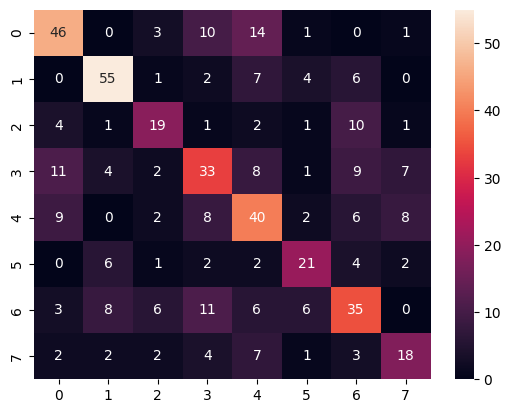

In [11]:
# [6] Evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val).argmax(axis=1)
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
f1 = f1_score(y_val, y_pred, average='macro')
assert f1 > 0.8, "F1 score requirement not met"

In [12]:
# [7] Save Model
model.save('emotion_model.h5')

In [13]:
pip install streamlit-audiorec


   ---------------------------------------- 0.0/872.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/872.8 kB ? eta -:--:--
   ------------------------ --------------- 524.3/872.8 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 872.8/872.8 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
